## Imports

In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json
import copy
from plotly.subplots import make_subplots
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
from datetime import datetime
import statistics

In [2]:
data = json.load(open('research/output/youtube_data.json'))

## Processing

In [3]:
persuasions = ["Social Identity", "Concreteness", "Anchoring and Comparison", "Overcoming Reactance", "Reciprocity",
"Foot in the Door", "Authority", "Social Impact", "Anthropomorphism", "Scarcity", "Social Proof", "Unclear"]
sector_list = {"Technology": "#19A7CE", 
               "Media": "#F24C3D", 
               "Retailing and Apparel": "#F2BE22", 
               "Finance": "#00DFA2", 
               "Food and Household": "#F97B22", 
               "Wholesalers, Industrials and Energy": "#77037B", 
               "Transportation": "#413543",
               "Aerospace and Defence": "#090580",
               "Healthcare": "#FFACAC"}
year_list = ["Before 2014", '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022']

In [4]:
frequency = {}
for video, values in data.items():
    for i, strat in enumerate(values["annots"]):
        if strat not in frequency:
            frequency[strat] = {"overall":0}
        frequency[strat]["overall"] += 1

In [5]:
df = pd.DataFrame.from_dict(frequency).T

In [6]:
companies = {}
for video, values in data.items():
    company = values["channelTitle"]
    if company not in companies:
        companies[company] = {"count":0, "videos":{}}
    y = values["publishedAt"][0:4]
    if int(y) <= 2013:
        y = "Before 2014"
    companies[company]["count"] += 1
    companies[company]["videos"][video] = {"annots":values["annots"], "publishedAt":values["publishedAt"], "publishedIn": y, "likeCount": values["likeCount"],
                                         "viewCount":values["viewCount"], "videoTag":"video "+str(companies[company]["count"]), "commentCount":values["commentCount"]}
companies = dict(sorted(companies.items(), key=lambda item: item[0]))

In [7]:
top_5_companies = sorted(companies.items(), key=lambda x: x[1]["count"], reverse=True)[:5]
top_5_company_names = [company[0] for company in top_5_companies]

In [9]:
sectors = {}
for sector in sector_list:
    sectors[sector] = {"count":0, "num_companies":0, "videos":{}}

for video, values in data.items():
    sec = values["sector"]
    company = values["channelTitle"]
    for sector in sectors:
        if sec in sector:
            y = values["publishedAt"][0:4]
            if int(y) <= 2013:
                y = "Before 2014"
            sectors[sector]["count"] += 1
            sectors[sector]["videos"][video] = {"annots":values["annots"], "commentCount": values['commentCount'], "channelTitle":company, "publishedIn": y, "likeCount": values["likeCount"],
                                                 "viewCount":values["viewCount"], "videoTag":"video "+str(companies[company]["count"])}

In [10]:
sector_list_org = {"Technology": {}, "Media": {}, "Retailing": {}, "Apparel": {}, "Finance": {}, "Food": {}, "Household": {}, 
               "Wholesalers": {}, "Industrials": {}, "Energy": {}, "Transportation": {}, "Aerospace and Defence": {}, "Healthcare": {}}
for video, values in data.items():
    sector = values["sector"]
    company = values["channelTitle"]
    if company not in sector_list_org:
        sector_list_org[values["sector"]][company] = 0

for sector in sector_list_org:
    sector_list_org[sector] = len(sector_list_org[sector])

In [11]:
for sector, vals in sectors.items():
    unique_comp = {}
    for _, content in vals["videos"].items():
        unique_comp[content["channelTitle"]] = 0
    vals["num_companies"] = len(unique_comp)

# Company

In [ ]:
class Company:
    def __init__(self, name, sector, views, likes, comments, outreach, engagement):
        self.name = name
        self.sector = sector
        self.views = views
        self.likes = likes
        self.comments = comments
        self.outreach = outreach
        self.engagement = engagement
        self.strategies = strategies

    def calculate_average_engagement(self):
        if not self.engagement_metrics:
            return 0
        
        total_engagement = sum(self.engagement_metrics.values())
        average_engagement = total_engagement / len(self.engagement_metrics)
        return average_engagement

    def __str__(self):
        return f"Company: {self.name}, Sector: {self.sector}"

## Company

In [12]:
company_views = {}
company_likes = {}
company_comments = {}
company_outreach = {}
company_engagement = {}
company_video_freq = {}
company_strategy = {}


for company, content in companies.items():
    company_views[company] = 0
    company_likes[company] = 0
    company_comments[company] = 0
    company_video_freq[company] = 0
    company_strategy[company] = {}
    for persuasion in persuasions:
        company_strategy[company][persuasion] = 0
    
    for video, values in content["videos"].items():
        strategies = values["annots"]
        company_views[company] += values["viewCount"]
        company_likes[company] += values["likeCount"]
        company_comments[company] += values["commentCount"]
        company_video_freq[company] += 1
        for strat in strategies:
            company_strategy[company][strat] += 1
                
    company_outreach[company] = company_views[company]/company_video_freq[company]
    # company_outreach[company] = company_views[company]
    company_engagement[company] = ((company_likes[company] + company_comments[company])/company_views[company])*company_video_freq[company]

sorted_company_outreach = dict(sorted(company_outreach.items(), key=lambda item: item[1], reverse=True))
sorted_company_engagement = dict(sorted(company_engagement.items(), key=lambda item: item[1], reverse=True))

In [13]:
company_data = {
    "Company": list(companies.keys()),
    "Views": list(company_views.values()),
    "Frequency": list(company_video_freq.values()),
    "Likes": list(company_likes.values()),
    "Comments": list(company_comments.values()),
    "Outreach": list(company_outreach.values()),
    "Engagement": list(company_engagement.values())
}

companies_df = pd.DataFrame(company_data)

def sort_dataframe(companies_df, attribute, ascending=True):
    return df.sort_values(by=attribute, ascending=ascending)

In [60]:
companies_df.sort_values(by="Frequency", ascending=False).head(10)

Company     Views  Frequency   Likes  Comments  \
96                Netflix  35123539         67  695164     37546   
140   Walt Disney Studios   9155817         43  155043      8911   
4    Adobe Creative Cloud   6012619         38   19190       347   
149            ultabeauty   4458953         37     657        38   
135      Viacom18 Studios   4254750         34   10393       202   
44                 Costco    223973         33     305        33   
95                 NVIDIA   3755634         28   33600      8933   
116      Sherwin-Williams    461511         26     818        56   
20      Bed Bath & Beyond   3514122         22     370        26   
35                 Clorox  24118319         22     931       166   

         Outreach  Engagement  
96   5.242319e+05    1.397683  
140  2.129260e+05    0.770005  
4    1.582268e+05    0.123475  
149  1.205122e+05    0.005767  
135  1.251397e+05    0.084665  
44   6.787061e+03    0.049801  
95   1.341298e+05    0.317103  
116  1.775042e+04    0.049238  
20   1.597328e+05    0.002479  
35   1.096287e+06    0.001001

**Interesting Insights**

Only 4 videos of coors light but few viral with 22M, 15M views
Only 15 second videos
Fewer than 100 likes and comments

Molson Coors' 2022 U.S. ad spending totaled $692 million, according to the Ad Age Datacenter.
The campaign won in the Design/Brand category at The Drum Awards for Marketing Americas 2023

**Intersting Insights**

Netflix kind of noise in our dataset? No real ads, but trailers of movies and series

Apple has surprisingly high engagement, even with comments disabled in all its videos

In [25]:
company_hypotheses = []

# Hypothesis 1: High Engagement Companies
high_engagement_companies = companies_df[companies_df['Engagement'] > 4*companies_df['Engagement'].mean()]
company_hypotheses.append("High Engagement Companies: " + str(high_engagement_companies['Company'].tolist()))

# Hypothesis 2: Most Viewed Companies
most_viewed_companies = companies_df[companies_df['Views'] == companies_df['Views'].max()]
company_hypotheses.append("Most Viewed Companies: " + str(most_viewed_companies['Company'].tolist()))

# Hypothesis 3: Correlation Between Likes and Comments
highest_corr_company = companies_df.loc[companies_df['Engagement'].idxmax()]['Company']
correlation_likes_comments = companies_df.corr().loc['Likes', 'Comments']
company_hypotheses.append(f"Company with the Highest Engagement: {highest_corr_company} (Correlation: {correlation_likes_comments:.2f})")

outreach_engagement_company = companies_df[companies_df['Outreach'] * companies_df['Engagement'] > companies_df['Outreach'].mean() * companies_df['Engagement'].mean()]
company_hypotheses.append("Companies with highest Outreach and Engagement: " + str(outreach_engagement_company['Company'].tolist()))

# Print hypotheses
for hypothesis in company_hypotheses:
    print(hypothesis)

High Engagement Companies: ['Boeing', 'Kroger', 'NVIDIA', 'Netflix', 'Northrop Grumman', 'Walt Disney Studios', 'Williams Sonoma']
Most Viewed Companies: ["DICK'S Sporting Goods"]
Company with the Highest Engagement: Netflix (Correlation: 0.93)
Companies with highest Outreach and Engagement: ['Adobe Creative Cloud', 'Apple', 'Kroger', 'NVIDIA', 'Netflix', 'Walt Disney Studios']


## Strategies

In [53]:
# Initialize dictionaries to store data per persuasion strategy
persuasion_views = {}
persuasion_likes = {}
persuasion_comments = {}
persuasion_views_list = {}
persuasion_likes_list = {}
persuasion_comments_list = {}
persuasion_engagement = {}
persuasion_outreach = {}
persuasion_video_frequency = {}
persuasion_engagement = {}
persuasion_outreach = {}
persuasion_engagement_list = {}
persuasion_outreach_list = {}

# Initialize a list to store plot dictionaries for updating visibility
plot_dicts = []

# Loop over all companies and their content
for company, content in companies.items():
    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likecount = values["likeCount"]
        commentcount = values["commentCount"]
        for strat in strats:
            # Initialize the data for each persuasion strategy
            if strat not in persuasion_views:
                persuasion_views[strat] = 0
                persuasion_likes[strat] = 0
                persuasion_comments[strat] = 0
                persuasion_views_list[strat] = []
                persuasion_likes_list[strat] = []
                persuasion_comments_list[strat] = []
                persuasion_video_frequency[strat] = 0
                persuasion_engagement[strat] = 0
                persuasion_outreach[strat] = 0
                persuasion_engagement_list[strat] = []
                persuasion_outreach_list[strat] = []

            # Update data for each persuasion strategy
            persuasion_views[strat] += viewcount
            persuasion_likes[strat] += likecount
            persuasion_comments[strat] += commentcount
            persuasion_views_list[strat].append(viewcount)
            persuasion_likes_list[strat].append(likecount)
            persuasion_comments_list[strat].append(commentcount)
            persuasion_video_frequency[strat] += 1
            persuasion_engagement[strat] += (likecount + commentcount)/viewcount
            persuasion_outreach[strat] += viewcount/len(persuasion_views_list[strat])
            persuasion_engagement_list[strat].append((likecount + commentcount)/viewcount)
            persuasion_outreach_list[strat].append(viewcount/len(persuasion_views_list[strat]))

# Calculate engagement for each persuasion strategy
for strat in persuasion_views:
    if persuasion_views[strat] != 0 and persuasion_video_frequency[strat] != 0:
        persuasion_engagement[strat] = ((persuasion_likes[strat] + persuasion_comments[strat]) / persuasion_views[strat])# * persuasion_video_frequency[strat]

for strat in persuasion_views:
    if persuasion_video_frequency[strat] != 0:
        persuasion_outreach[strat] = persuasion_views[strat] / persuasion_video_frequency[strat]

In [54]:
sorted_likes = sorted(persuasion_likes.items(), key=lambda x: x[1], reverse=True)
sorted_views = sorted(persuasion_views.items(), key=lambda x: x[1], reverse=True)
sorted_comments = sorted(persuasion_comments.items(), key=lambda x: x[1], reverse=True)
sorted_frequency = sorted(persuasion_video_frequency.items(), key=lambda x: x[1], reverse=True)

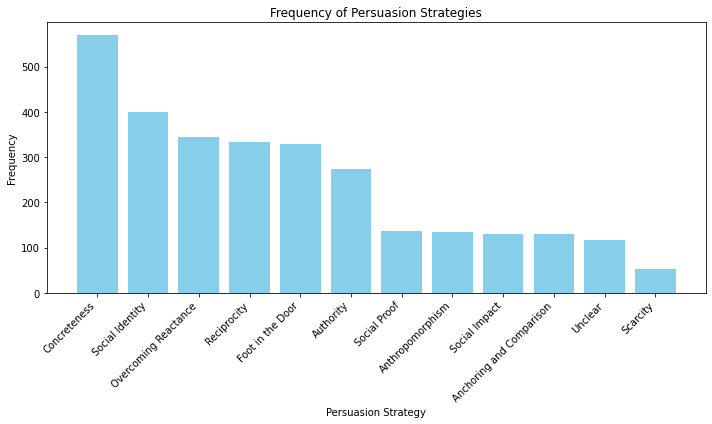

In [55]:
keys, values = zip(*sorted_frequency)

plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')

plt.xlabel('Persuasion Strategy')
plt.ylabel('Frequency')
plt.title('Frequency of Persuasion Strategies')

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

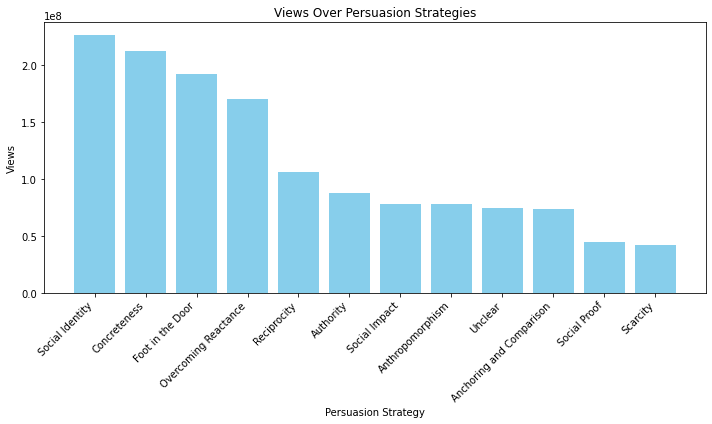

In [56]:
keys, values = zip(*sorted_views)

plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')

plt.xlabel('Persuasion Strategy')
plt.ylabel('Views')
plt.title('Views Over Persuasion Strategies')

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

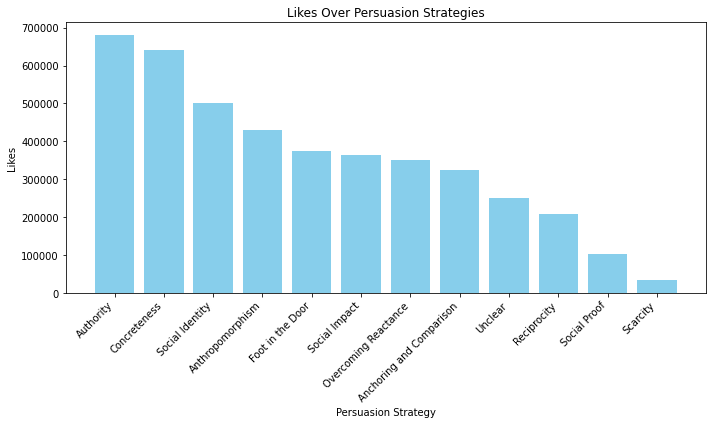

In [57]:
keys, values = zip(*sorted_likes)

plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')

plt.xlabel('Persuasion Strategy')
plt.ylabel('Likes')
plt.title('Likes Over Persuasion Strategies')

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

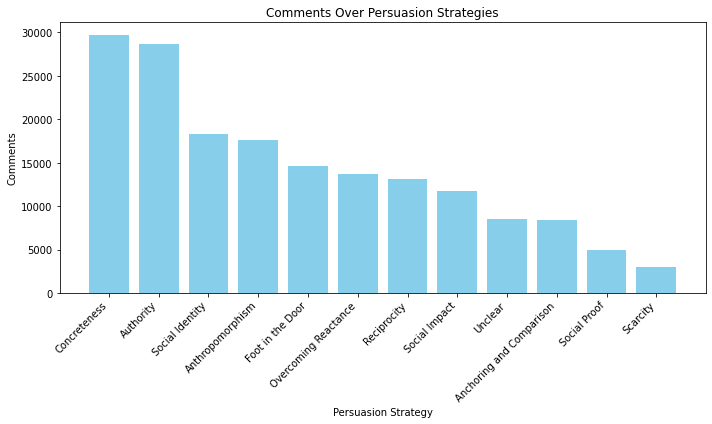

In [414]:
keys, values = zip(*sorted_comments)

plt.figure(figsize=(10, 6))
plt.bar(keys, values, color='skyblue')

plt.xlabel('Persuasion Strategy')
plt.ylabel('Comments')
plt.title('Comments Over Persuasion Strategies')

plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()

**Hypothesis:** Anthropomorphism has significantly high likes to views and comments to views ratio/consistently high engagement

**Hypothesis:** Despite high frequency and views reciprocity ranks lower in engagement

**Hypothesis:** Scarcity and Social Proof are underutilised strategies

In [58]:
strategies_data = {
    "Strategy": list(persuasion_views.keys()),
    "Views": list(persuasion_views.values()),
    "Likes": list(persuasion_likes.values()),
    "Comments": list(persuasion_comments.values()),
    "Engagement": list(persuasion_engagement.values()),
    "Outreach": list(persuasion_outreach.values()),
    "Frequency": list(persuasion_video_frequency.values())
}

strategies_df = pd.DataFrame(strategies_data)

In [59]:
strategies_df.sort_values(by="Engagement", ascending=False)

Strategy      Views   Likes  Comments  Engagement  \
2                  Authority   87644691  679769     28696    0.008083   
8           Anthropomorphism   77815029  428936     17635    0.005739   
10             Social Impact   78520385  363933     11700    0.004784   
5   Anchoring and Comparison   73478244  323383      8394    0.004515   
4                    Unclear   75007548  249967      8464    0.003445   
6               Concreteness  212208118  640112     29678    0.003156   
11              Social Proof   44452733  102280      4937    0.002412   
7            Social Identity  226287096  502318     18343    0.002301   
0       Overcoming Reactance  170255969  351997     13679    0.002148   
1                Reciprocity  106511419  208330     13078    0.002079   
3           Foot in the Door  192349112  373962     14598    0.002020   
9                   Scarcity   41799861   33898      3029    0.000883   

         Outreach  Frequency  
2   321042.824176        273  
8   580709.171642        134  
10  599392.251908        131  
5   565217.261538        130  
4   646616.793103        116  
6   372949.240773        569  
11  324472.503650        137  
7   567135.578947        399  
0   494930.142442        344  
1   319854.111111        333  
3   584647.756839        329  
9   788676.622642         53

In [42]:
strategy_hypotheses = []

# Hypothesis 1: High Engagement with Specific Strategies
high_engagement_strategies = strategies_df[strategies_df['Engagement'] > strategies_df['Engagement'].mean()]
strategy_hypotheses.append("Strategies with high engagement: " + str(high_engagement_strategies['Strategy'].tolist()))

# Hypothesis 2: Underutilized Strategies
underutilized_strategies = strategies_df[(strategies_df['Frequency'] > strategies_df['Frequency'].mean()) & (strategies_df['Engagement'] < strategies_df['Engagement'].mean())]
strategy_hypotheses.append("Underutilized strategies: " + str(underutilized_strategies['Strategy'].tolist()))

# Hypothesis 3: Strategy with the Highest Likes-to-Views Ratio
highest_likes_to_views = strategies_df[strategies_df['Likes'] / strategies_df['Views'] == strategies_df['Likes'] / strategies_df['Views'].max()]
strategy_hypotheses.append("Strategy with the highest likes-to-views ratio: " + str(highest_likes_to_views['Strategy'].values[0]))

# Hypothesis 4: Strategy with the Highest Comments-to-Views Ratio
highest_comments_to_views = strategies_df[strategies_df['Comments'] / strategies_df['Views'] == strategies_df['Comments'] / strategies_df['Views'].max()]
strategy_hypotheses.append("Strategy with the highest comments-to-views ratio: " + str(highest_comments_to_views['Strategy'].values[0]))

# Print strategy hypotheses
for hypothesis in strategy_hypotheses:
    print(hypothesis)

Strategies with high engagement: ['Authority', 'Concreteness', 'Social Identity']
Underutilized strategies: ['Overcoming Reactance', 'Reciprocity', 'Foot in the Door']
Strategy with the highest likes-to-views ratio: Social Identity
Strategy with the highest comments-to-views ratio: Social Identity


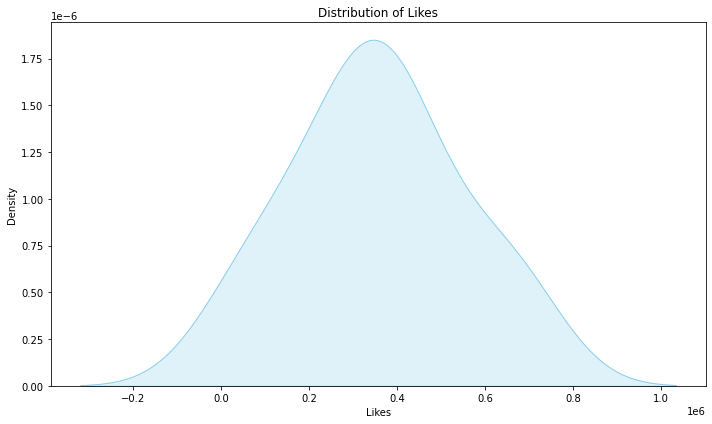

In [510]:
_, likes_values = zip(*sorted_likes)
_, views_values = zip(*sorted_views)
_, comments_values = zip(*sorted_comments)

plot_data = pd.DataFrame({
    'Likes': likes_values,
    # 'Views': views_values,
    'Comments': comments_values
})

plt.figure(figsize=(10, 6))
sns.kdeplot(likes_values, shade=True, color='skyblue')
# sns.kdeplot(data=plot_data, shade=True)

plt.xlabel('Likes')
plt.ylabel('Density')
plt.title('Distribution of Likes')

plt.tight_layout()
plt.show()

In [135]:
mean_likes = []
stdev_likes = []
for strat in persuasion_likes:
    mean_likes.append((strat, statistics.mean(persuasion_likes_list[strat])))
    stdev_likes.append((strat, statistics.stdev(persuasion_likes_list[strat])))

In [136]:
for a in stdev_likes:
    print(a)

('Overcoming Reactance', 13299.055588249495)
('Reciprocity', 2563.5075690590206)
('Authority', 20497.639955165672)
('Foot in the Door', 13640.646525244956)
('Unclear', 10348.710092081044)
('Anchoring and Comparison', 21739.198628107424)
('Concreteness', 10716.32166442022)
('Social Identity', 12795.431080148084)
('Anthropomorphism', 21705.93826513151)
('Scarcity', 1395.2865494773448)
('Social Impact', 21759.265599400398)
('Social Proof', 3875.583855057539)


In [44]:
likes_consistency = []
for strat in persuasion_likes:
    m = statistics.mean(persuasion_likes_list[strat])
    c = 0
    for vid in persuasion_likes_list[strat]:
        if vid > m:
            c += 1
    likes_consistency.append((strat, (c/persuasion_video_frequency[strat])))

In [45]:
for strat, c in sorted(likes_consistency):
    print(strat, c*100)

Anchoring and Comparison 3.076923076923077
Anthropomorphism 8.208955223880597
Authority 4.395604395604396
Concreteness 8.963093145869948
Foot in the Door 5.167173252279635
Overcoming Reactance 4.941860465116279
Reciprocity 11.11111111111111
Scarcity 18.867924528301888
Social Identity 6.265664160401002
Social Impact 6.870229007633588
Social Proof 10.948905109489052
Unclear 7.758620689655173


In [46]:
engagement_consistency = []
for strat in persuasion_engagement:
    m = statistics.mean(persuasion_engagement_list[strat])
    c = 0
    for vid in persuasion_engagement_list[strat]:
        if vid > m:
            c += 1
    engagement_consistency.append((strat, (c/persuasion_video_frequency[strat])))

In [48]:
for strat, c in sorted(engagement_consistency):
    print(strat, c*100)

Anchoring and Comparison 29.230769230769234
Anthropomorphism 26.865671641791046
Authority 26.00732600732601
Concreteness 27.416520210896312
Foot in the Door 26.13981762917933
Overcoming Reactance 26.16279069767442
Reciprocity 26.426426426426424
Scarcity 32.075471698113205
Social Identity 27.31829573934837
Social Impact 24.427480916030532
Social Proof 27.73722627737226
Unclear 30.17241379310345


In [49]:
outreach_consistency = []
for strat in persuasion_outreach:
    m = statistics.mean(persuasion_outreach_list[strat])
    c = 0
    for vid in persuasion_outreach_list[strat]:
        if vid > m:
            c += 1
    outreach_consistency.append((strat, (c/persuasion_video_frequency[strat])))

In [50]:
for strat, c in sorted(outreach_consistency):
    print(strat, c*100)

Anchoring and Comparison 13.076923076923078
Anthropomorphism 13.432835820895523
Authority 10.256410256410255
Concreteness 10.369068541300527
Foot in the Door 10.030395136778116
Overcoming Reactance 10.465116279069768
Reciprocity 10.81081081081081
Scarcity 13.20754716981132
Social Identity 12.531328320802004
Social Impact 15.267175572519085
Social Proof 11.678832116788321
Unclear 9.482758620689655


In [43]:
likes_to_views = []

for strat in persuasion_views:
    if strat in persuasion_likes and persuasion_views[strat] != 0:
        likes = persuasion_likes[strat]
        views = persuasion_views[strat]
        ratio = likes / views
        likes_to_views.append((strat, ratio))

sorted_likes_to_views = sorted(likes_to_views, key=lambda x: x[1], reverse=True)

for strat, ratio in sorted_likes_to_views:
    print(f'Strategy: {strat}, Likes-to-Views Ratio: {ratio:.5f}')

Strategy: Authority, Likes-to-Views Ratio: 0.00776
Strategy: Anthropomorphism, Likes-to-Views Ratio: 0.00551
Strategy: Social Impact, Likes-to-Views Ratio: 0.00463
Strategy: Anchoring and Comparison, Likes-to-Views Ratio: 0.00440
Strategy: Unclear, Likes-to-Views Ratio: 0.00333
Strategy: Concreteness, Likes-to-Views Ratio: 0.00302
Strategy: Social Proof, Likes-to-Views Ratio: 0.00230
Strategy: Social Identity, Likes-to-Views Ratio: 0.00222
Strategy: Overcoming Reactance, Likes-to-Views Ratio: 0.00207
Strategy: Reciprocity, Likes-to-Views Ratio: 0.00196
Strategy: Foot in the Door, Likes-to-Views Ratio: 0.00194
Strategy: Scarcity, Likes-to-Views Ratio: 0.00081


In [ ]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store data per persuasion strategy
persuasion_views = {}
persuasion_likes = {}

# Loop over all companies and their content
for company, content in companies.items():
    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likecount = values["likeCount"]
        for strat in strats:
            # Initialize the data for each persuasion strategy
            if strat not in persuasion_views:
                persuasion_views[strat] = []
                persuasion_likes[strat] = []

            # Append views and likes for each video to the respective lists
            persuasion_views[strat].append(viewcount)
            persuasion_likes[strat].append(likecount)

# Create a plot for each persuasion strategy
for strat, views_list in persuasion_views.items():
    likes_list = persuasion_likes[strat]
    
    # Create a scatter plot of views vs. likes for this persuasion strategy
    plt.scatter(views_list, likes_list, label=strat)

# Add labels and a legend
plt.xlabel('Views')
plt.ylabel('Likes')
plt.title('Scatter Plot of Likes vs. Views by Persuasion Strategy')
plt.legend()

# Show the plot
plt.show()

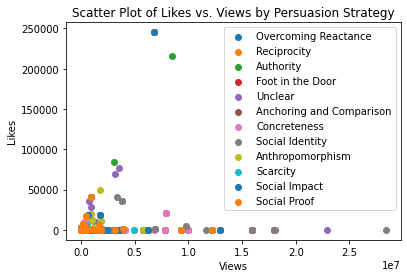

In [402]:
import matplotlib.pyplot as plt

# Initialize dictionaries to store data per persuasion strategy
persuasion_views = {}
persuasion_likes = {}

# Loop over all companies and their content
for company, content in companies.items():
    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likecount = values["likeCount"]
        for strat in strats:
            # Initialize the data for each persuasion strategy
            if strat not in persuasion_views:
                persuasion_views[strat] = []
                persuasion_likes[strat] = []

            # Append views and likes for each video to the respective lists
            persuasion_views[strat].append(viewcount)
            persuasion_likes[strat].append(likecount)

# Create a plot for each persuasion strategy
for strat, views_list in persuasion_views.items():
    likes_list = persuasion_likes[strat]
    
    # Create a scatter plot of views vs. likes for this persuasion strategy
    plt.scatter(views_list, likes_list, label=strat)

# Add labels and a legend
plt.xlabel('Views')
plt.ylabel('Likes')
plt.title('Scatter Plot of Likes vs. Views by Persuasion Strategy')
plt.legend()

# Show the plot
plt.show()


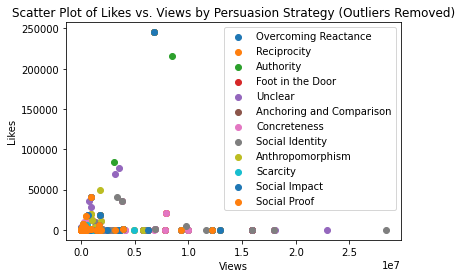

## Engagement Metrics

### KPIs

In [31]:
graphs_v = []
graphs_l = []
graphs_c = []

num_companies = len(companies)
plot_dicts = []
top_5_likes = []
top_5_comments = []

j = 0
for company, content in companies.items():    
    company_views = {}
    company_likes = {}
    company_comments = {}
    video_frequency = {}
    for pers in persuasions:
        company_views[pers] = 0
        company_likes[pers] = 0
        company_comments[pers] = 0
        video_frequency[pers] = 0

    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likecount = values["likeCount"]
        commentcount = values["commentCount"]
        for strat in strats:
            video_frequency[strat] += 1
            company_views[strat] += viewcount
            company_likes[strat] += likecount
            company_comments[strat] += commentcount
    
#     for key in company_views:
#         if video_frequency[key] != 0:
#             company_views[key] /= video_frequency[key]
#             company_likes[key] /= video_frequency[key]
    
    strat_names = []
    v = []
    l = []
    c = []
    for key in company_views:
        if company_views[key] == 0 and company_likes[key] == 0:
            pass
        else:
            strat_names.append(key)
            v.append(company_views[key])
            l.append(company_likes[key])
            c.append(company_comments[key])
    if j == 0:
        visible_action = True
    else:
        visible_action = False
            
    g_v = go.Pie(labels=strat_names, values=v, name = company, visible = visible_action)
    graphs_v.append(g_v)
    
    g_l = go.Pie(labels=strat_names, values=l, name = company, visible = visible_action)
    graphs_l.append(g_l)
    
    g_c = go.Pie(labels=strat_names, values=c, name = company, visible = visible_action)
    graphs_c.append(g_c)
    
    if company in top_5_company_names:
        top_5_likes.append(g_l)
        top_5_comments.append(g_c)

    visibility = [False]*num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}], 
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j+=1

**Views**

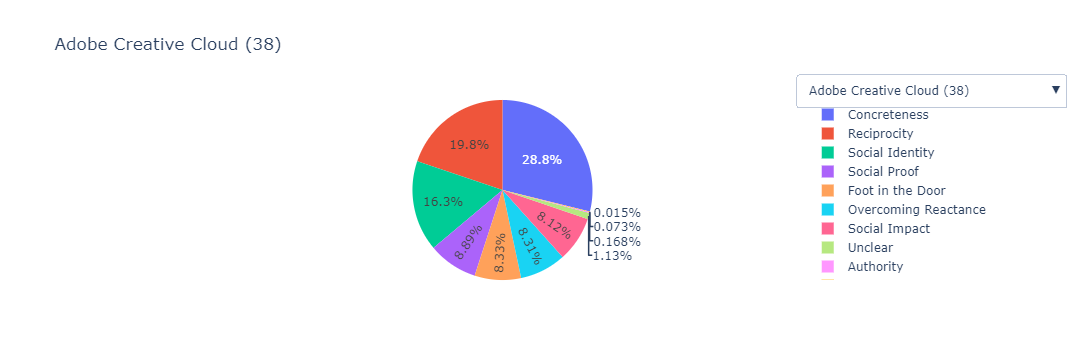

In [23]:
fig = go.Figure(data = graphs_v)
fig.update_layout(
    updatemenus=[dict(buttons= plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Trend of number of views per video gathered by each company.html")

**Likes**

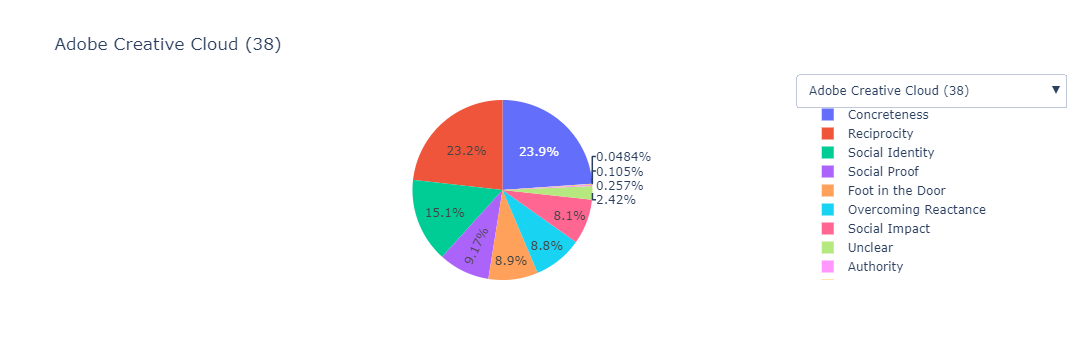

In [24]:
fig = go.Figure(data = graphs_l)
fig.update_layout(
    updatemenus=[dict(buttons= plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Trend of number of likes per video gathered by each company.html")

**Comments**

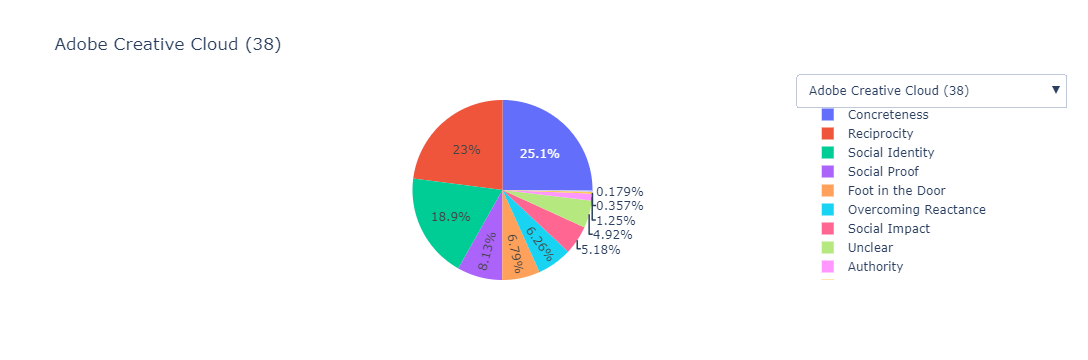

In [34]:
fig = go.Figure(data = graphs_c)
fig.update_layout(
    updatemenus=[dict(buttons= plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Trend of number of likes per video gathered by each company.html")

### Outreach Metric

In [35]:
graphs_o = []

num_companies = len(companies)
plot_dicts = []
top_5_outreach = []
j = 0

for company, content in companies.items():    
    company_views = {}
    company_outreach = {}
    video_frequency = {}
    for pers in persuasions:
        company_views[pers] = 0
        video_frequency[pers] = 0

    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        for strat in strats:
            video_frequency[strat] += 1
            company_views[strat] += viewcount
            company_outreach[strat] = 0
    
    for strat in company_views:
        if video_frequency[strat] != 0:
            company_outreach[strat] = company_views[strat]/video_frequency[strat]
    
    strat_names = []
    o = []
    
    for key in company_views:
        if company_views[key] == 0:
            pass
        else:
            strat_names.append(key)
            o.append(company_outreach[key])

    if j == 0:
        visible_action = True
    else:
        visible_action = False
            
    g_o = go.Pie(labels=strat_names, values=o, name = company, visible = visible_action)
    graphs_o.append(g_o)
    
    if company in top_5_company_names:
        top_5_outreach.append(g_o)

    visibility = [False]*num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}], 
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j+=1

In [63]:
print(graphs_o[0])

Pie({
    'labels': [Social Identity, Concreteness, Anchoring and Comparison, Overcoming
               Reactance, Reciprocity, Foot in the Door, Authority, Unclear],
    'name': '3M',
    'values': [6676.333333333333, 6676.333333333333, 10523.0, 6467.666666666667,
               5797.75, 6467.666666666667, 6842.5, 1315218.0],
    'visible': True
})


In [73]:
print(top_5_outreach[0])

Pie({
    'labels': [Social Identity, Concreteness, Anchoring and Comparison, Overcoming
               Reactance, Reciprocity, Foot in the Door, Authority, Social Impact,
               Anthropomorphism, Social Proof, Unclear],
    'name': 'Adobe Creative Cloud',
    'values': [250653.53846153847, 250905.26086956522, 7301.0, 151179.45454545456,
               220255.27777777778, 128223.07692307692, 6725.2, 541577.0, 1500.0,
               296472.6666666667, 32371.85714285714],
    'visible': False
})


In [66]:
top_3_strategies_outreach = {}
n = 3

for company in graphs_o:
    top_3_strategies_outreach[company["name"]] = []
    for i in range(n):
        top_3_strategies_outreach[company["name"]].append(company["labels"][i])

In [69]:
top_3_strategies_outreach = {}
n = 3

for company in graphs_o:
    top_n_strategies = []

    sorted_indices = sorted(range(len(company["values"])), key=lambda i: company["values"][i], reverse=True)

    for i in range(n):
        if i < len(sorted_indices):
            top_n_strategies.append(company["labels"][sorted_indices[i]])

    top_3_strategies_outreach[company["name"]] = top_n_strategies
    break

In [70]:
print(top_3_strategies_outreach)

{'3M': ['Unclear', 'Anchoring and Comparison', 'Authority']}


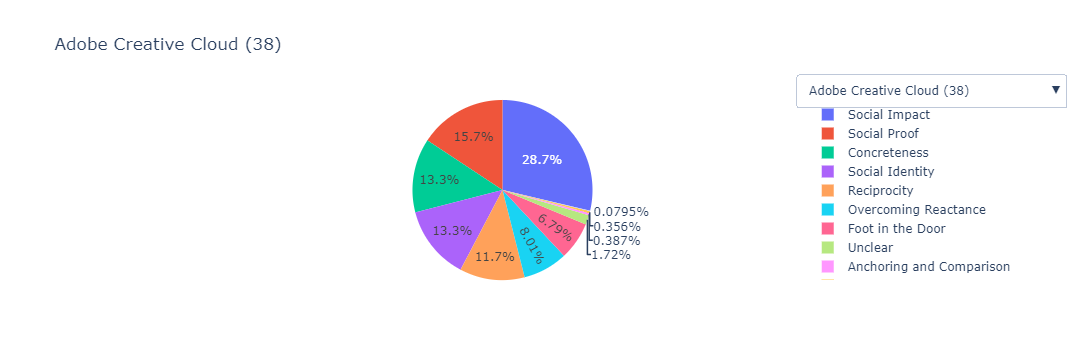

In [36]:
fig = go.Figure(data = graphs_o)
fig.update_layout(
    updatemenus=[dict(buttons= plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Trend of number of likes per video gathered by each company.html")

### Engagement Metric

In [33]:
graphs_v = []
graphs_l = []
graphs_c = []
graphs_e = []

num_companies = len(companies)
plot_dicts = []
top_5_likes = []
top_5_comments = []
top_5_engagements = []

j = 0
for company, content in companies.items():    
    company_views = {}
    company_likes = {}
    company_comments = {}
    company_engagement = {}
    video_frequency = {}
    for pers in persuasions:
        company_views[pers] = 0
        company_likes[pers] = 0
        company_comments[pers] = 0
        video_frequency[pers] = 0

    for video, values in content["videos"].items():
        strats = values["annots"]
        viewcount = values["viewCount"]
        likecount = values["likeCount"]
        commentcount = values["commentCount"]
        for strat in strats:
            video_frequency[strat] += 1
            company_views[strat] += viewcount
            company_likes[strat] += likecount
            company_comments[strat] += commentcount
            company_engagement[strat] = 0
    
    for strat in company_views:
        if company_views[strat] != 0 and video_frequency != 0:
            company_engagement[strat] = ((company_likes[strat] + company_comments[strat])/company_views[strat])*video_frequency[strat]
            # company_engagement[strat] = ((company_likes[strat] + company_comments[strat])/company_views[strat])/video_frequency[strat]
    
    strat_names = []
    v = []
    l = []
    c = []
    e = []
    
    for key in company_views:
        if company_views[key] == 0:
            pass
        else:
            strat_names.append(key)
            v.append(company_views[key])
            l.append(company_likes[key])
            c.append(company_comments[key])
            e.append(company_engagement[key])
    if j == 0:
        visible_action = True
    else:
        visible_action = False
            
    g_e = go.Pie(labels=strat_names, values=e, name = company, visible = visible_action)
    graphs_e.append(g_e)
    
    if company in top_5_company_names:
        top_5_likes.append(g_l)
        top_5_comments.append(g_c)
        top_5_engagements.append(g_e)

    visibility = [False]*num_companies
    visibility[j] = True
    d = dict(args=[{"visible": visibility}, {"title": company + " (" + str(content["count"]) + ")"}], 
             label=company + " (" + str(content["count"]) + ")", method="update")
    plot_dicts.append(d)
    j+=1

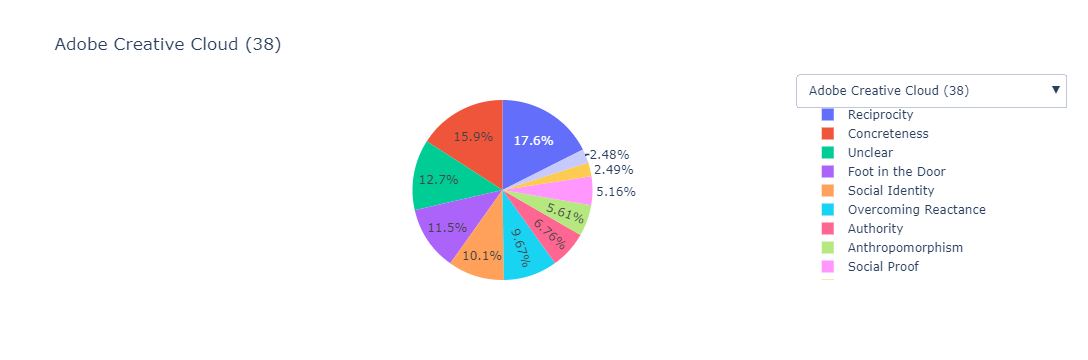

In [55]:
fig = go.Figure(data = graphs_e)
fig.update_layout(
    updatemenus=[dict(buttons= plot_dicts,
                      pad={"r": 10, "t": 10},
                      showactive=True,
                      x=1,
                      xanchor="left",
                      y=1.2,
                      yanchor="top")]
)
fig.show()
# plotly.offline.plot({"data": fig}, filename = "Trend of number of likes per video gathered by each company.html")

In [79]:
for i in range(5):
    outreach_values = top_5_outreach[i]['values']
    engagement_values = top_5_engagements[i]['values']
    
    cosine_similarity = 1 - cosine(outreach_values, engagement_values)
    
    print(f"Cosine similarity between Outreach Values and Engagement Values for {top_5_outreach[i]['name']}: {cosine_similarity:.2f}")

Cosine similarity between Outreach Values and Engagement Values for Adobe Creative Cloud: 0.63
Cosine similarity between Outreach Values and Engagement Values for Netflix: 0.85
Cosine similarity between Outreach Values and Engagement Values for Viacom18 Studios: 0.21
Cosine similarity between Outreach Values and Engagement Values for Walt Disney Studios: 0.83
Cosine similarity between Outreach Values and Engagement Values for ultabeauty: 0.10


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing

cosine_similarities = {}
engagement_vector = {}
outreach_vector = {}

for persuasion in persuasions:
    cosine_similarities[persuasion] = [[0] * len(graphs_e)] * 2

for i in range(len(graphs_e)):
    for index, p in enumerate(graphs_e[i]['labels']):
        cosine_similarities[p][1][i] = graphs_e[i]['values'][index]

for persuasion in persuasions:
    engagement_vector[persuasion] = cosine_similarities[persuasion][1].copy()
    engagement_vector[persuasion] = preprocessing.normalize([engagement_vector[persuasion]])[0]

for i in range(len(graphs_o)):
    for index, p in enumerate(graphs_o[i]['labels']):
        cosine_similarities[p][0][i] = graphs_o[i]['values'][index]

for persuasion in persuasions:
    outreach_vector[persuasion] = cosine_similarities[persuasion][0]
    outreach_vector[persuasion] = preprocessing.normalize([outreach_vector[persuasion]])[0]

In [37]:
for p in persuasions:
    cosine_similarity = (1 - cosine(outreach_vector[p], engagement_vector[p]))   
    print(f"Cosine similarity between Outreach Values and Engagement Values for {p}: {cosine_similarity:.3f}")

Cosine similarity between Outreach Values and Engagement Values for Social Identity: 0.070
Cosine similarity between Outreach Values and Engagement Values for Concreteness: 0.054
Cosine similarity between Outreach Values and Engagement Values for Anchoring and Comparison: 0.164
Cosine similarity between Outreach Values and Engagement Values for Overcoming Reactance: 0.065
Cosine similarity between Outreach Values and Engagement Values for Reciprocity: 0.037
Cosine similarity between Outreach Values and Engagement Values for Foot in the Door: 0.039
Cosine similarity between Outreach Values and Engagement Values for Authority: 0.049
Cosine similarity between Outreach Values and Engagement Values for Social Impact: 0.082
Cosine similarity between Outreach Values and Engagement Values for Anthropomorphism: 0.083
Cosine similarity between Outreach Values and Engagement Values for Scarcity: 0.012
Cosine similarity between Outreach Values and Engagement Values for Social Proof: 0.022
Cosine s

In [522]:
for i in range(len(graphs_o)):
    outreach_values = graphs_o[i]['values']
    engagement_values = graphs_e[i]['values']
    
    cosine_similarity = 1 - cosine(outreach_values, engagement_values)
    
    print(f"Cosine similarity between Outreach Values and Engagement Values for {graphs_o[i]['name']}: {cosine_similarity:.2f}")

## Market Basket Analysis

In [164]:
company_strategies = {}
for company, content in companies.items():
    company_strategies[company] = set()
    for video, values in content["videos"].items():
        for strat in values["annots"]:
            company_strategies[company].add(strat)

company_strategies = {company: list(strategies) for company, strategies in company_strategies.items()}

In [171]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

def binarize_data(companies, persuasions):
    binary_data = []
    for company, data in companies.items():
        transaction = [1 if persuasion in data else 0 for persuasion in persuasions]
        binary_data.append(transaction)
    return binary_data

# Perform Apriori analysis
def perform_apriori(binary_data, min_support=0.1, min_confidence=0.5):
    df = pd.DataFrame(binary_data, columns=persuasions)
    frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_confidence)
    return rules

# Example usage
binary_data = binarize_data(company_strategies, persuasions)
rules = perform_apriori(binary_data, min_support=0.5, min_confidence=0.8)

D:\Softwares\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [172]:
rules

antecedents  \
0                          (Social Identity)   
1                             (Concreteness)   
2                     (Overcoming Reactance)   
3                          (Social Identity)   
4                              (Reciprocity)   
5                          (Social Identity)   
6                          (Social Identity)   
7                         (Foot in the Door)   
8                                (Authority)   
9                          (Social Identity)   
10                    (Overcoming Reactance)   
11                            (Concreteness)   
12                             (Reciprocity)   
13                            (Concreteness)   
14                            (Concreteness)   
15                        (Foot in the Door)   
16                               (Authority)   
17                            (Concreteness)   
18                    (Overcoming Reactance)   
19                             (Reciprocity)   
20                    (Overcoming Reactance)   
21                        (Foot in the Door)   
22                    (Overcoming Reactance)   
23                               (Authority)   
24   (Overcoming Reactance, Social Identity)   
25      (Overcoming Reactance, Concreteness)   
26           (Social Identity, Concreteness)   
27                    (Overcoming Reactance)   
28                         (Social Identity)   
29                            (Concreteness)   
30           (Social Identity, Concreteness)   
31       (Social Identity, Foot in the Door)   
32          (Concreteness, Foot in the Door)   
33                         (Social Identity)   
34                            (Concreteness)   
35                        (Foot in the Door)   
36              (Authority, Social Identity)   
37                 (Authority, Concreteness)   
38           (Social Identity, Concreteness)   
39                               (Authority)   
40                         (Social Identity)   
41                            (Concreteness)   
42   (Overcoming Reactance, Social Identity)   
43  (Overcoming Reactance, Foot in the Door)   
44       (Social Identity, Foot in the Door)   
45                    (Overcoming Reactance)   
46                         (Social Identity)   
47                        (Foot in the Door)   
48      (Overcoming Reactance, Concreteness)   
49  (Overcoming Reactance, Foot in the Door)   
50          (Concreteness, Foot in the Door)   
51                    (Overcoming Reactance)   
52                            (Concreteness)   
53                        (Foot in the Door)   

                                 consequents  antecedent support  \
0                             (Concreteness)            0.766667   
1                          (Social Identity)            0.880000   
2                          (Social Identity)            0.686667   
3                     (Overcoming Reactance)            0.766667   
4                          (Social Identity)            0.600000   
5                              (Reciprocity)            0.766667   
6                         (Foot in the Door)            0.766667   
7                          (Social Identity)            0.620000   
8                          (Social Identity)            0.640000   
9                                (Authority)            0.766667   
10                            (Concreteness)            0.686667   
11                    (Overcoming Reactance)            0.880000   
12                            (Concreteness)            0.600000   
13                             (Reciprocity)            0.880000   
14                        (Foot in the Door)            0.880000   
15                            (Concreteness)            0.620000   
16                            (Concreteness)            0.640000   
17                               (Authority)            0.880000   
18                             (Reciprocity)            0.686667   
19                    (Overcomin

In [193]:
# Create an empty set to store unique combinations
unique_combinations = set()

# Iterate through the rules and add unique combinations to the set
for i in range(54):
    antecedents = list(rules.iloc[i]['antecedents'])
    consequents = list(rules.iloc[i]['consequents'])
    
    combs = []
    for a in antecedents:
        combs.append(a)
        
    for c in consequents:
        combs.append(c)
    
    # Convert the list to a frozenset to make it hashable
    comb_set = frozenset(combs)
    
    unique_combinations.add(comb_set)

# Convert the unique combinations back to lists if needed
# unique_combinations = [list(comb_set) for comb_set in unique_combinations]

In [190]:
# print(unique_combinations)

[['Reciprocity', 'Social Identity'], ['Overcoming Reactance', 'Social Identity'], ['Social Identity', 'Concreteness']]


In [194]:
# Create a dictionary to store the accumulated likeCount for each unique combination
combination_likes = {comb: 0 for comb in unique_combinations}

for company, content in companies.items():
    for video, values in content["videos"].items():
        video_strats = values["annots"]
        for combin in unique_combinations:
            if all(strat in video_strats for strat in combin):
                # If all strategies in the unique combination are present in the video, accumulate likeCount
                combination_likes[combin] += values["likeCount"]

In [205]:
df_combination_likes = pd.DataFrame(list(combination_likes.items()), columns=["Combination", "Likes"])

# Sort the DataFrame by Likes in descending order
df_combination_likes = df_combination_likes.sort_values(by="Likes", ascending=False)

# Reset the index for the sorted DataFrame
df_combination_likes = df_combination_likes.reset_index(drop=True)

In [227]:
df_combination_likes

Combination                                         Likes 
0                     (Social Identity, Concreteness)  434687
1                           (Authority, Concreteness)  364161
2                    (Concreteness, Foot in the Door)  349448
3            (Overcoming Reactance, Foot in the Door)  343388
4                        (Authority, Social Identity)  327461
5                (Overcoming Reactance, Concreteness)  324986
6          (Authority, Social Identity, Concreteness)  324713
7   (Overcoming Reactance, Concreteness, Foot in t...  319718
8                 (Social Identity, Foot in the Door)  311431
9   (Social Identity, Concreteness, Foot in the Door)  309844
10            (Overcoming Reactance, Social Identity)  309550
11  (Overcoming Reactance, Social Identity, Concre...  306120
12  (Overcoming Reactance, Social Identity, Foot i...  305307
13                  (Overcoming Reactance, Authority)  291451
14                        (Reciprocity, Concreteness)  156416
15                     (Reciprocity, Social Identity)   89927
16                (Overcoming Reactance, Reciprocity)   71306